# Example of learning recurrent weights for a 2-D signal

## To-Do:

   * Fixed optimal balanced network and neuron death
   * Learning recurrent connectivity in loosely balanced networks
   * Neuron death and recurrent plasticity
   
This notebook simulates an example network of 16 neurons with adaptive recurrent connectivity encoding a two-dimensional signal.

## 1. Simulations

### a) Header definitions

Packages for simulating the network:

* math
* os
* sys
* Numpy
* Numpy.Random
* Numpy.Linalg
* statsmodels.api

In [34]:
### NATIVE
import math
import os
import sys

### NUMPY
import numpy as np
import numpy.random as rand
import numpy.linalg as LA

### SCIPY
import scipy.signal as sp

### STATS
import statsmodels.api as sm

### b) Functions to generate input signals

* **get_oscillat_input**: returns input signal running on a circle

In [8]:
def get_oscillat_input(time, ampl, freq, offs, noise_var = 0.0):
    ampl = ampl*np.ones(2) if isinstance(ampl, float) else ampl
    freq = freq*np.ones(2) if isinstance(freq, float) else freq
    offs = offs*np.ones(2) if isinstance(offs, float) else offs
    x       = np.zeros((2,len(time)))             # define input array
    x[:,:]  = [ ampl[0] * np.cos(freq[0]*time) + offs[0],  
                ampl[1] * np.sin(freq[1]*time) + offs[1]]  # periodic signal (2D circle)
    x[:,0]  = 0                                   # initial values
    x      += noise_var*rand.randn(2,len(time)) # adding zero-mean white noise
    return x

### c) Helper functions for neuron ablations and tuning curve estimation

In [9]:
def ablate_neuron(neuron, ts, F, W, V):
    """ Ablate i-th neuron at time step ts """
    print("Ablate neuron", neuron, "at", ts*dt, "s")
    F[neuron,:]  = 0
    W[neuron,:]  = 0
    W[:,neuron]  = 0
    V       = 0. 
    return F, W, V

def tuning_curves(t, x, r):
    lowess=[]
    angle = np.arctan2(x[1,t[0]:t[1]],x[0,t[0]:t[1]])
    for neuron in range(N):
        print("Neuron:", neuron)
        delta = (angle.max() - angle.min())*0.01
        temp = sm.nonparametric.lowess(r[neuron,t[0]:t[1]], angle, frac=0.1, delta = delta)
        lowess.append(temp)
    return lowess

### d) Function to run simulation

In [23]:
### Quick global options
_LEARNREC = False                     # use learning for recurrent weights
_LEARNFF  = False                     # use learning for feed-forward weights
_COST     = False                     # use quadratic cost term
_OPTI_REC = True                      # use optimal weights for recurrent conn. (W = FD)
_OPTI_DEC = False                     # use optimal weights for decoding conn. (D = F.T)
_VERBOSE  = False                     # Printout
_MULTI    = False                     # multiruns
_NOABLATE = True                      # no ablation
_DEC_IN   = False                     # constantly updating the decoder 

### Global parameters
_mu       = 0.01
_beta     = 2.0
_beta1    = 1.0
_ablstart = 50.
_ablate   = []
_ablrate  = 0.01
_stop_after = 16

def run(N, time, signal=0.0):
    """ This function simulates an N-dim. network for a given time
    
        RETURNS
        o      === spike trains of each neuron               || (nparray)
        V      === membrane potentials of each neuron        || (nparray)
        y      === spike trains of each neuron               || (nparray)
        r      === firing rates                              || (nparray)
        F      === feed-forward weights (fixed)              || (nparray)
        W      === recurrent weights (adapted)               || (nparray)
        Wo     === initial recurrent weights                 || (nparray)
        dW     === change of recurrent weights               || (nparray)
        W_all  === all recurrent weights for video           || (nparray)
        D      === decoding weights (fixed)                  || (nparray)
        
        ARGS
        N      === number of neurons in network              || (int)
        time   === time array                                || (nparray)
        signal === input (default:0.0)                       || (float/nparray)
        
    """

    np.random.seed(seed=42)
    ### input dim (fixed=2) and time
    M  = 2                                                   # input dims
    dt = time[1]-time[0]                                     # integration time step
    T  = dt*len(time)                                        # total duration
    
    
    ### state containers
    V  = np.zeros((N,len(time)))                             # membrane potential
    o  = np.zeros((N,len(time)))                             # spike trains
    r  = np.zeros((N,len(time)))                             # firing rates
    y  = np.zeros((M,len(time)))                             # readout
    st = []                                                  # spike times + index    
    
    
    ### input from args
    x  = signal                                              # input signal
    if isinstance(x, float):                                 # if float is given
        x *= np.ones((M,len(time)))                          # make sure input is correct dims
    
    
    ### network weights and firing threshold
    angles  = np.linspace(0, 2*np.pi, num=N, endpoint=False) # angles in [0,2PI) equally spaced
    angles += 0.00*2.*np.pi*rand.randn(N)
    
    ## FEED-FORWARD
    F       = np.array([np.cos(angles),np.sin(angles)]).T    # feed-forward connections
    F      *= 1.0                                            # scaling
    Fo      = np.copy(F)                                     # initial feed-forward weights
    
    ## RECURRENT
    mu      = _mu if _COST else 0.0                          # regularization constant (e-6)
    rvec    = rand.rand(N,1)                                 # uniformly distributed random vector
    #Wransym = rvec.dot(rvec.T)                              # random recurrent connections (symmetric)
    Wrand   = rand.randn(N,N)/(N*N)                          # random recurrent connections (non-symmetric)
    Wopt    = F.dot(F.T) + mu * np.eye(N)                    # optimal weights
    W       = np.zeros((N,N))
    W       = Wopt if _OPTI_REC else Wrand                   # choosing recurrent weights
    W      *= 1.                                             # scaling
    Wo      = np.copy(W)                                     # initial recurrent weights
    dW      = np.zeros((N, len(time)))                       # weight change vector
    W_all   = np.zeros((len(time),N,N))                      # container for all recurrent weights over time (video)
    
    ## DECODING
    D       = np.zeros((M,N))                                # decoder weights
    d1      = np.zeros((M,N))            
    d2      = 0.0
    
    
    ### constant parameters
    #Thr     = np.diag((F).dot(F.T))/2 + (mu/2)*np.ones(N)    # thresholds
    #Thr     = np.diag(W)/2 + (mu/2)*np.ones(N)    # threshold
    Thr     = 0.5*np.ones(N)
    beta1   = 2*Thr - mu * np.ones(N)  
    leak = 1.                                                # leak constant
    etaW = 0.02 if _LEARNREC else 0.0                        # learning rate for recurrent weights (0.01 worked)
    etaF = 0.0001 if _LEARNFF else 0.0                       # learning rate for feed-forward weights
    
    if _VERBOSE:
        evals, evecs = LA.eigh(W)
        print("Feed-forward weights:", F)
        print("Recurrent weights:", W)
        print("Spectral radius:", evals)
        print("Threshold:", Thr)
     
    ### ablations
    nabl    = 16                                             # number of ablations
    tabl    = _ablstart                                      # start of ablations
    ablen   = _ablrate*nabl                                  # duration of ablations
    ablate_t= (np.arange(tabl, tabl+ablen, ablen/nabl))/dt   # ablation times (start at halftime in short window)
    ablate_t.resize(_stop_after)
    ablate_t= ablate_t.astype(int)
    if _NOABLATE:
        ablate_t = []
    if _VERBOSE:
        print("Ablations at t=", ablate_t*dt,"secs.")
    ablated = []
    to_ablate = _ablate
    
    ### initial values
    V[:,0]  = -Thr
    #r[0,:] = x[0,0]
    #r[1,:] = x[1,0]/ np.sin(angles[1])
    
    ### running simulation
    print("Start simulation for", time[-1]+time[1],"seconds.")
    for i,t in enumerate(time[:-1]):
        
        ## storing weights
        W_all[i] = W
        
        ## ablations
        for ind, times in enumerate(ablate_t):
            if i == times:
                if len(to_ablate)==0:
                    rand_neuron = rand.randint(N)
                    while rand_neuron in ablated:
                        rand_neuron = rand.randint(N)
                else:
                    if ind < len(to_ablate):
                        rand_neuron = to_ablate[ind]
                if rand_neuron not in ablated:
                    F, W, V[:,i] = ablate_neuron(rand_neuron,i, F, W, V[:,i])
                    ablated.append(rand_neuron)
        
        ## input update
        c = x[:,i] + (x[:,i+1]-x[:,i])/dt                                      # neural input
        
        ## membrane potential update
        dV       = -V[:,i] + F.dot(c) - W.dot(o[:,i])                          # ODE membrane potential
        V[:,i+1] = V[:,i] + dt*leak*dV                                         # Euler integration
        #V[:,i+1] = np.clip(V[:,i+1], -Thr, np.inf)                          # clip membrane potential
        
        ## spikes update
        o[:,i+1] = (V[:,i+1] > Thr)                                            # check for spikes
        if np.sum(o[:,i+1])>0:
            special_flake = rand.choice(np.ravel(np.nonzero(o[:,i+1])), 1)[0]  # look who's a special flake...
            o[:,i+1]      = np.eye(N)[special_flake]/dt                        # only one spike per time step
            st.append([t, special_flake])
            
            ## weight update only if spike
            #beta = beta1/(2.*(Thr + mu * np.mean(r[:,:i],axis=1)))
            min_spikes = 100
            if len(st) > min_spikes and _LEARNREC:                             # start learning after 100 spikes
                dW[:,i] = _beta*(V[:,i] + mu*r[:,i]) - W[:,special_flake] + _beta1*mu*np.eye(N)[special_flake]  
                #dW[:,i] = 2*V[:,i] - W[:,special_flake]                       # learning rule for
                #W[i+1,:,:] = W[i,:,:]
                W[:,special_flake] += etaW * dW[:,i]                           # adapting recurrent weights 
              
        ## firing rates update
        dr       = -r[:,i] + o[:,i+1]                                          # ODE firing rates
        r[:,i+1] = r[:,i] + dt*leak*dr                                         # Euler integration
        
        ## decoding inside
        if _DEC_IN:
            Finv = LA.pinv(F)
            if _OPTI_DEC:
                D  = F.T
            else:
                D  = np.dot(Finv,W)
            y[:,i+1]  = D.dot(r[:,i+1])
            
        #d1 += x[:,i]*r[:,i+1].T
        #d2 += r[i,tstart:tend]*np.sum(r[:,tstart:tend])
        
        ## regular printouts (every 10%)
        if math.fmod(100*t/T,10)==0:
            print(int(100*t/T), "%\t", "t:",t, "s")
            
            
    ### Alternative: decoding matrix from pseudoinv(F)*W
    if not _DEC_IN:
        Finv1 = LA.pinv(Fo)
        Finv2 = LA.pinv(F)
        htime = int(tabl/dt)

        ### Calculate readouts
        if htime < T: 
            D1 = np.dot(Finv1,W_all[htime])
            D2 = np.dot(Finv2,W)
            y[:,:htime]   = D1.dot(r[:,:htime])
            y[:,htime+1:] = D2.dot(r[:,htime+1:])
        else:
            if _OPTI_DEC:
                D  = F.T
                if not _NOABLATE:
                    D  = F.T
            else:
                D  = np.dot(Finv2,W)
                if not _NOABLATE:
                    D  = np.dot(Finv2,W)
            y  = D.dot(r)
        
        
    ### Return
    print(100, "%\t", "t:",T, "s")
    print("Done.")
    return o, V, y, r, F, Fo, W, Wo, dW, W_all, D 

## 2. Experiments

### a) Only learning

In [11]:
### simulation parameter
N    = 16                  # number of neurons
T    = 200.                # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array
np.random.seed(seed=42)    # comment if you want to get different random spiking
_LEARNREC = True           # use learning for recurrent weights
_LEARNFF  = False          # use learning for feed-forward weights
_COST     = True           # use quadratic cost term
_OPTI_REC = False          # use optimal weights for recurrent conn. (W = FD)
_OPTI_DEC = False          # use optimal weights for recurrent conn. (D = F.T)
_mu  = 0.01                # 0.01 works
_beta = 2.0 #0.818181

### generate input signal
ampl = 5.
circ = get_oscillat_input(time, ampl, 1., 0.)                               # Circle
#circ = get_oscillat_input(time, ampl, np.array([1.,2.]), 0.)                 # Narrow eight
#circ = get_oscillat_input(time, np.array([ampl,0.5*ampl]), np.array([1.,2.]), 0.) # Wide eight
#circ = get_oscillat_input(time, np.array([0.,5.]), np.array([1.,2.]), 0.)  # Line

### run simulation
o, V, y, r, F, Fo, W, Wo, dW, allW, D = run(N, time, circ)

Start simulation for 200.0 seconds.
0 %	 t: 0.0 s
10 %	 t: 20.0 s
20 %	 t: 40.0 s
30 %	 t: 60.0 s
40 %	 t: 80.0 s
50 %	 t: 100.0 s
60 %	 t: 120.0 s
70 %	 t: 140.0 s
80 %	 t: 160.0 s
90 %	 t: 180.0 s
100 %	 t: 200.0 s
Done.


### b) Learning and ablations

#### To-DO:

* Decoder weights updated constantly deltaD = beta*(x-y) - D e_j

In [59]:
### simulation parameter
N    = 16                  # number of neurons
T    = 2000.               # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array
np.random.seed(seed=42)    # comment if you want to get different random spiking

### quick options
_LEARNREC = True         ### # use learning for recurrent weights
_LEARNFF  = False          # use learning for feed-forward weights
_COST     = True           # use quadratic cost term
_OPTI_REC = True         ### # use optimal weights for recurrent conn. (W = FD)
_OPTI_DEC = False          # use optimal weights for recurrent conn. (D = F.T)

### other parameters
_mu  = 0.01                # 0.01 works
_beta = 2.0 #0.818181
_beta1 = 0.0 #0.818181

### ablations
_DEC_IN   = True           # constant updates of decoder
_NOABLATE = False          # ABLATIONS
#_ablate   = [num for num in range(16)] # ordered
_ablate = rand.permutation(N)                  # random
_ablstart = 10.
_ablrate  = 100.
_stop_after = 10

### generate input signal
ampl = 5.
circ = get_oscillat_input(time, ampl, 1., 0.)                               # Circle
#circ = get_oscillat_input(time, ampl, np.array([1.,2.]), 0.)                 # Narrow eight
#circ = get_oscillat_input(time, np.array([ampl,0.5*ampl]), np.array([1.,2.]), 0.) # Wide eight
#circ = get_oscillat_input(time, np.array([0.,5.]), np.array([1.,2.]), 0.)  # Line

### run simulation
abl_o, abl_V, abl_y, abl_r, abl_F, abl_Fo, abl_W, abl_Wo, abl_dW, abl_allW, abl_D = run(N, time, circ) 
_LEARNREC = False         ### # use learning for recurrent weights
stat_o, stat_V, stat_y, stat_r, stat_F, stat_Fo, stat_W, stat_Wo, stat_dW, stat_allW, stat_D = run(N, time, circ)

Start simulation for 2000.0 seconds.
0 %	 t: 0.0 s
Ablate neuron 0 at 10.0 s
Ablate neuron 1 at 110.0 s
10 %	 t: 200.0 s
Ablate neuron 5 at 210.0 s
Ablate neuron 14 at 310.0 s
20 %	 t: 400.0 s
Ablate neuron 13 at 410.0 s
Ablate neuron 11 at 510.0 s
30 %	 t: 600.0 s
Ablate neuron 8 at 610.0 s
Ablate neuron 9 at 710.0 s
40 %	 t: 800.0 s
Ablate neuron 2 at 810.0 s
Ablate neuron 15 at 910.0 s
50 %	 t: 1000.0 s
60 %	 t: 1200.0 s
70 %	 t: 1400.0 s
80 %	 t: 1600.0 s
90 %	 t: 1800.0 s
100 %	 t: 2000.0 s
Done.
Start simulation for 2000.0 seconds.
0 %	 t: 0.0 s
Ablate neuron 0 at 10.0 s
Ablate neuron 1 at 110.0 s
10 %	 t: 200.0 s
Ablate neuron 5 at 210.0 s
Ablate neuron 14 at 310.0 s
20 %	 t: 400.0 s
Ablate neuron 13 at 410.0 s
Ablate neuron 11 at 510.0 s
30 %	 t: 600.0 s
Ablate neuron 8 at 610.0 s
Ablate neuron 9 at 710.0 s
40 %	 t: 800.0 s
Ablate neuron 2 at 810.0 s
Ablate neuron 15 at 910.0 s
50 %	 t: 1000.0 s
60 %	 t: 1200.0 s
70 %	 t: 1400.0 s
80 %	 t: 1600.0 s
90 %	 t: 1800.0 s
100 %	 t: 2

## 3. Plotting

### a) Header definitions

Packages for plotting the results:

* matplotlib.pyplot
* matplotlib.legend_handler.HandlerLine2D
* matplotlib.image
* scipy.interpolate.UnivariateSpline
* svgutils.transform

Color definitions from FlatUI and Matplotlib's colormaps.

In [2]:
### MATPLOTLIB
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.image as mpimg
%matplotlib inline

### SCIPY
from scipy.interpolate import UnivariateSpline

import svgutils.transform as sg
from basic_units import radians, degrees, cos

### DEFINE COLORS (FLAT UI & RAINBOW)
flatui = {  'alizarin'   : "#e74c3c",
            'peter_river': "#3498db",
            'emerald'    : "#2ecc71",
            'sunflower'  : "#f1c40f",
            'carrot'     : "#e67e22",
            'amethyst'   : "#9b59b6",
            'turquoise'  : "#1abc9c",
            'wet_asphalt': "#34495e",
            'pomegranate': "#c0392b",
            'belize_hole': "#2980b9",
            'orange'     : "#f39c12"
        }
N       = 16
rainbow = plt.get_cmap('rainbow', N)
winter  = plt.get_cmap('winter_r', N)
curcmap = winter

### b) General plotting function


Here we define plot functions used later in this notebook.

* **multiplot**: Takes an array of one-dimensional signals to be plotted (for time series in same plot).

* **rasterplot**: Creates a spike raster plot for given spike train and time array.

* **rasterplot_half**: Like rasterplot, but spikes are spaced (for placing membrane potential below). Option to add population spikes.

* **hide_ax**: Returns axes without right-upper borders.

* **ax_signal_space**:

* **ax_weight_space**:

* **plot_signal_weights**:

In [182]:
def multiplot(ax,x,arr):
    colors = curcmap
    for i, y in enumerate(arr):
        ax.plot(x, y, '-', c=colors(i))
    return ax

def rasterplot(ax, time, spikes):
    N = len(spikes)
    colors = curcmap
    for neuron in range(N):
        posy = (1+neuron)*spikes[neuron, spikes[neuron,:]==1]
        ax.vlines(time[spikes[neuron,:]==1], posy-0.5, posy+0.5, colors=colors(neuron))
    ax.set_ylim([0.5, N+0.5])
    ax.set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    ax.set_yticks(np.arange(spacer,N+1,spacer))
    return ax

def rasterplot_half(ax, time, spikes, pos=[0.25, 0.6], pop=True):
    N = len(spikes)
    pop_spikes = np.sum(spikes, axis=0)
    dt = time[1]
    colors = curcmap
    for neuron in range(N):
        posy = (1+neuron)*spikes[neuron, spikes[neuron,:]==1]
        ax.vlines(time[spikes[neuron,:]==1], posy+pos[0], posy+pos[1], colors=colors(neuron), lw=2)
    if pop:        
        ax.vlines(time[pop_spikes==1], N+0.75, N+1.25, colors='k', lw=2)    
        ax.set_ylim([0, N+2])
    else:
        ax.set_ylim([0, N+1])
    ax.set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    ax.set_yticks(np.arange(spacer,N+1,spacer))
    return ax


def hide_ax(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    return ax

def ax_signal_space(ax, x, y, scale, t):
    # data plotting
    ax.plot(y[0,t[0]:t[1]], y[1,t[0]:t[1]], c=flatui['belize_hole'], label="$\mathbf{y}(t)$")
    ax.plot(x[0,t[0]:t[1]], x[1,t[0]:t[1]], c=flatui['alizarin'], label="$\mathbf{x}(t)$")
    
    # legend/labels
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel("$x_1$", fontsize=12)
    ax.set_ylabel("$x_2$",rotation=0, fontsize=12)
    
    # scale/ticks
    sc = 1.2*scale
    ax.set_xlim([-sc,sc])
    ax.set_ylim([-sc,sc])
    tick=scale/2
    ax.set_xticks(np.arange(-scale,scale+tick,tick))
    ax.set_yticks(np.arange(-scale,scale+tick,tick))
    
    return ax

def ax_weight_space(ax, F, D, scale):
    # data plotting (only one goes to legend)
    for ind in range(N):
        if ind==0:
            ax.plot(F[ind,0], F[ind,1], 'o', mfc = curcmap(ind), mec='k', markersize=12, markeredgewidth=2, label='$(\mathbf{F}^T)_i$')
            ax.plot(D[0,ind], D[1,ind], 'o', mfc= curcmap(ind), mec='#bbbbbb', markersize=8, markeredgewidth=2, label='$\mathbf{D}_i$')
        else:
            ax.plot(F[ind,0], F[ind,1], 'o', mfc = curcmap(ind), mec='k', markersize=12, markeredgewidth=2)
            ax.plot(D[0,ind], D[1,ind], 'o', mfc= curcmap(ind), mec='#bbbbbb', markersize=8, markeredgewidth=2)        
        
    # legend/labels
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel("$D_1$", fontsize=12)
    ax.set_ylabel("$D_2$",rotation=0, fontsize=12)
    
    # scale/ticks
    sc = 1.2*scale
    ax.set_xlim([-sc,sc])
    ax.set_ylim([-sc,sc])
    tick=scale/2
    ax.set_xticks(np.arange(-scale,scale+tick,tick))
    ax.set_yticks(np.arange(-scale,scale+tick,tick))
    
    return ax

def plot_signal_weights(x, y, F, D, scalex, scaleF, t, noweights=False):
    if noweights:
        f, ax = plt.subplots(1, figsize=(2.7,2.5))
        ax = ax_signal_space(ax, x, y, scalex, t)
        ax.legend(bbox_to_anchor=(1.5, 1), ncol=1, frameon=False)
    else:
        f, ax = plt.subplots(2, figsize=(2.7,5))
        ax[0] = ax_signal_space(ax[0], x, y, scalex, t)
        ax[0].legend(bbox_to_anchor=(1.5, 1), ncol=1, frameon=False)
        ax[1] = ax_weight_space(ax[1], F, D, scaleF)
        ax[1].legend(bbox_to_anchor=(1.5, 1), ncol=1, numpoints=1, frameon=False, markerscale=0.75, handletextpad=-0.075)
    f.subplots_adjust(hspace = .4)
    return f, ax

def plot_signal_weights_hori(x, y, F, D, scalex, scaleF, t, noweights=False, nolegend=False):
    if noweights:
        f, ax = plt.subplots(1, figsize=(2.7,2.5))
        ax = ax_signal_space(ax, x, y, scalex, t)
        ax.legend(bbox_to_anchor=(1.5, 1), ncol=1, frameon=False)
    else:
        f, ax = plt.subplots(1,2, figsize=(6.,3))
        ax[0] = ax_signal_space(ax[0], x, y, scalex, t)
        if not nolegend:
            ax[0].legend(bbox_to_anchor=(0.5, -0.2), ncol=1, frameon=False)
        ax[1] = ax_weight_space(ax[1], F, D, scaleF)
        if not nolegend:
            ax[1].legend(bbox_to_anchor=(0.5, -0.2), ncol=1, numpoints=1, frameon=False, markerscale=0.75, handletextpad=-0.075)
    f.subplots_adjust(wspace = 1.)
    if nolegend:
        ax[0].legend().set_visible(False)
        ax[1].legend().set_visible(False)
    return f, ax

def plot_time_series(time, o, r, t, size=[5,5]):
    ### Figure 2: time series
    figs = 2
    f, ax = plt.subplots(figs, 1, figsize=(size[0], size[1]),sharex=True)

    ### additional measures
    dt = time[1]
    pop_rate = np.mean(r,axis=0)  # population activity
    pop_var  = np.var(r,axis=0)   # population variance

    ### Row 0: spike raster plot
    ax[0] = rasterplot(ax[0], time[t[0]:t[1]], o[:,t[0]:t[1]]*dt)
    ax[0].set_ylabel("Neuron index", fontsize=12)
    
    ### Row 1: rates time series
    ax[1] = multiplot(ax[1], time, [rate for rate in r])
    ax[1].plot(time[t[0]:t[1]], pop_rate[t[0]:t[1]], "-", c= "#ffff00", lw=2)
    ax[1].set_ylabel("Firing rates", fontsize=12)
    ax[1].set_xlabel("Time", fontsize=12)
    maxr = np.amax(r[:,t[0]:t[1]])
    minr = np.amin(r[:,t[0]:t[1]])
    ax[1].set_ylim([1.05*minr, 1.05*maxr])
    ax[1].set_yticks(np.arange(0, maxr, 1))
    
    f.subplots_adjust(hspace = .0)
    return f, ax

def plot_weight_evo(Wo, W_all, nfigs, t, _sc=12):
    figs = nfigs + 1
    sc = (_sc/figs)
    f, ax = plt.subplots(1, figs, figsize=(figs*sc,sc))
    colmap = "RdBu"
    cbsc = 1
    for ind,iax in enumerate(ax):
        tind = int(((ind*(t[1]-t[0]))/nfigs+t[0])/dt)
        print(tind*dt)
        if tind == int(T/dt):
            tind -= 2
        im=iax.imshow(-W_all[tind], cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation = 'nearest')
        iax.axis("off")
        
    cbax = f.add_axes([0.91, 0.175, 0.006, 0.68])
    cbar = f.colorbar(im, ax=ax[-1], cax = cbax, label="Syn. strength")
    cbar.set_ticks(np.arange(-1.0,1.5,0.5))
    f.suptitle(r'Recurrent weights $\mathbf{W}$(t)', fontsize=12, y=1.12)
    f.subplots_adjust(wspace = .3)
    return f, ax

### c) Figure 4A-B: circular input (signal space: signals and weights)

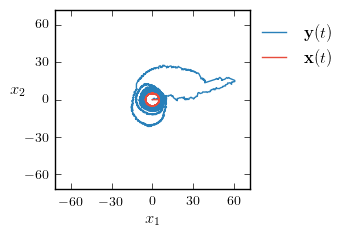

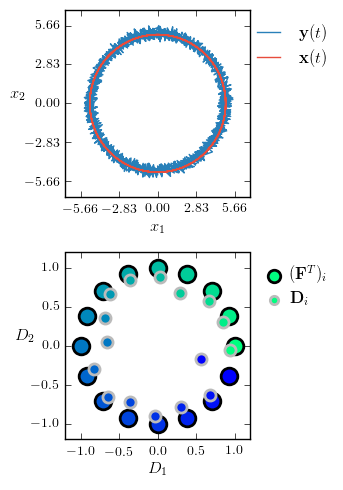

In [13]:
start = [int((0.)/dt), int(50./dt)]
f, ax = plot_signal_weights(circ, y, F, D, 60., 1., start, True)
plt.tight_layout()
f.savefig("./plots/Fig4leftup.svg", dpi=900)
plt.show()
end = [int((T-50.)/dt), int(T/dt)]
f, ax = plot_signal_weights(circ, y, F, D, np.amax(y[:,end[0]:]), 1., end)
plt.tight_layout()
f.savefig("./plots/Fig4leftdown.svg", dpi=900)
plt.show()


### d) Figure 4C: time series and weight evolution (first 50 secs)

0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0


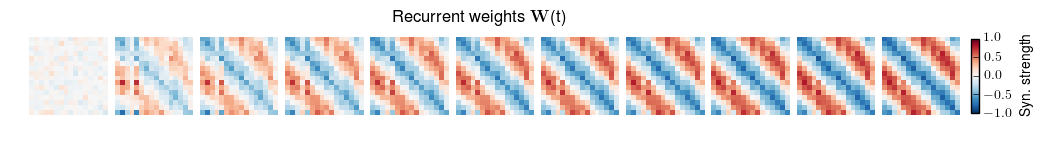

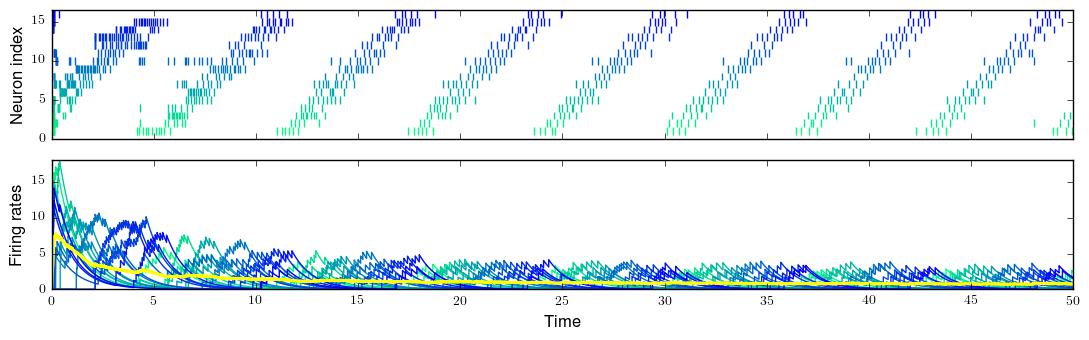

In [375]:
nfs = 10
f, ax = plot_weight_evo(Wo, allW, nfs, [0., 50.])
#plt.tight_layout()
f.savefig("./plots/Fig4rightup.svg", dpi=900)
plt.show()
f, ax = plot_time_series(time, o, r, [0, int(50./dt)], [11,3.5])
ax[0].set_xlim([0.,50])
ax[0].set_yticks(np.arange(0,16,5))
ax[1].set_yticks(np.arange(0,25,5))
ax[0].set_xticks(np.linspace(0,50,num=nfs+1))
ax[1].set_xticks(np.linspace(0,50,num=nfs+1))
ax[1].set_ylim([0.,18])
ax[1].set_xlim([0.,50])
plt.tight_layout()
f.savefig("./plots/Fig4rightcenterup.svg", dpi=900)
plt.show()

### e) Figure 4D: time series and weight evolution (final 50 secs)

150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
200.0


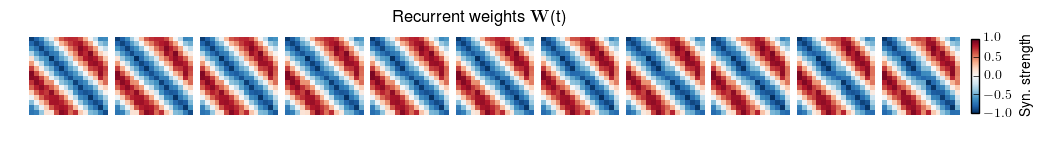

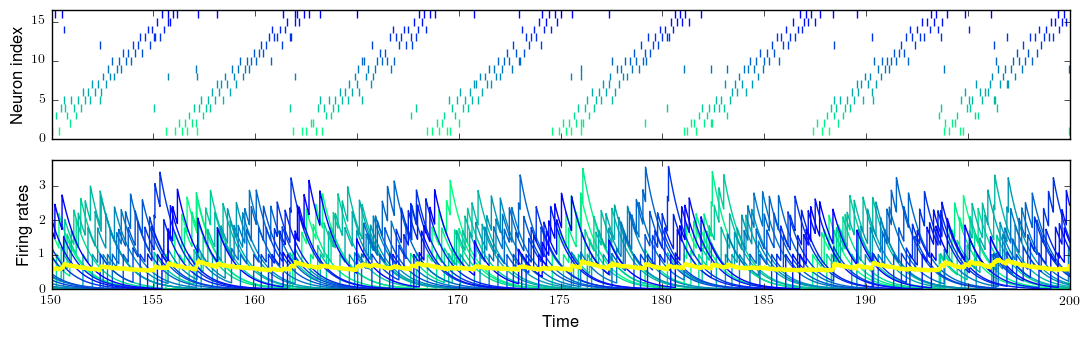

In [376]:
nfs = 10
f, ax = plot_weight_evo(Wo, allW, nfs, [T-50., T])
#plt.tight_layout()
f.savefig("./plots/Fig4rightcenterdown.svg", dpi=900)
plt.show()
f, ax = plot_time_series(time, o, r, [int((T-50.)/dt), int(T/dt)], [11,3.5])
ax[0].set_yticks(np.arange(0,16,5))
ax[0].set_xlim([T-50., T])
ax[1].set_xlim([T-50., T])
ax[0].set_xticks(np.linspace(T-50,T,num=nfs+1))
ax[1].set_xticks(np.linspace(T-50,T,num=nfs+1))
plt.tight_layout()
f.savefig("./plots/Fig4rightdown.svg", dpi=900)
plt.show()

## 4. Join panels together into Figure 4 (using SVGs)

This cell could be put into a generic function using an array of files

Output size: 1058px 695px


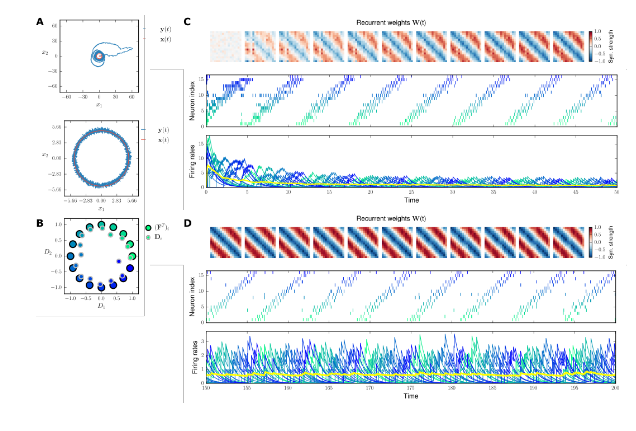

In [14]:
def toInt(string):
    return int(string.replace("pt", ""))

" join figures together "
#create new SVG figure
fig = sg.SVGFigure()

# load matpotlib-generated figures
curr_dir = "/Users/degoldschmidt/workspace/network-rotation/plots"
panels = [ sg.fromfile(curr_dir + "/Fig4leftup.svg"),
           sg.fromfile(curr_dir + "/Fig4leftdown.svg"),
           sg.fromfile(curr_dir + '/Fig4rightup.svg'),
           sg.fromfile(curr_dir + '/Fig4rightcenterup.svg'),
           sg.fromfile(curr_dir + '/Fig4rightcenterdown.svg'),
           sg.fromfile(curr_dir + '/Fig4rightdown.svg')]

# get the plot objects and move them to right position
plots = []
sizes = []

for ind, panel in enumerate(panels):
    plots.append(panel.getroot())
    wid, hei = panel.get_size()
    sizes.append([toInt(wid), toInt(hei)])

offs = 10
anc = 0
yoff = 0
plots[0].moveto(anc, anc+yoff)
plots[1].moveto(anc, anc+sizes[0][1]+yoff)

anc = sizes[0][0]
offs2 = 70
offs3 = 10
plots[2].moveto(anc+offs3, offs+10)
plots[3].moveto(anc+offs2, sizes[2][1]+offs+10)
plots[4].moveto(anc+offs3, offs+sizes[0][1]+sizes[0][1]-yoff)
plots[5].moveto(anc+offs2,  sizes[4][1]+offs+sizes[0][1]+sizes[0][1]-yoff)
newwid = sizes[0][0]+sizes[1][0]+sizes[2][0]

newwid = str(sizes[0][0]+sizes[2][0])+"px"
newhei = str(2*(sizes[2][1]+sizes[3][1])+35)+"px"
print("Output size:",newwid, newhei)
fig.set_size([newwid, newhei])


# add text labels
fsize = 18
offs = 20
txtA = sg.TextElement(0,offs-yoff, "A", size=fsize, weight="bold")
txtB = sg.TextElement(0,offs+sizes[0][1]+sizes[0][1]-yoff, "B", size=fsize, weight="bold")
txtC = sg.TextElement(anc+offs2,offs, "C", size=fsize, weight="bold")
txtD = sg.TextElement(anc+offs2,offs+sizes[0][1]+sizes[0][1]-yoff, "D", size=fsize, weight="bold")


# append plots and labels to figure
fig.append([plots[5], plots[4],plots[3], plots[2], plots[1], plots[0]])
fig.append([txtA, txtB, txtC, txtD])

# save generated SVG files
fig.save(curr_dir + "/Fig4.svg")
# svg-to-pdf conversion using Inkscape
inkscape = "/Applications/Inkscape.app/Contents/Resources/script --without-gui"
folder = "/Users/degoldschmidt/workspace/network-rotation/plots/"
filesvg = folder + "Fig4.svg"
filepdf = folder + "Fig4.pdf"
filepng = folder + "Fig4pre.png"
os.system(inkscape + " --export-pdf=" + filepdf + " " + filesvg)
os.system(inkscape + " --export-png=" + filepng + " " + filesvg)
# show preview png
plt.figure(figsize=(13,5))
image = mpimg.imread(filepng)
plt.imshow(image)
plt.axis("off")
plt.show()

## 5. Plotting Figure 5 parts

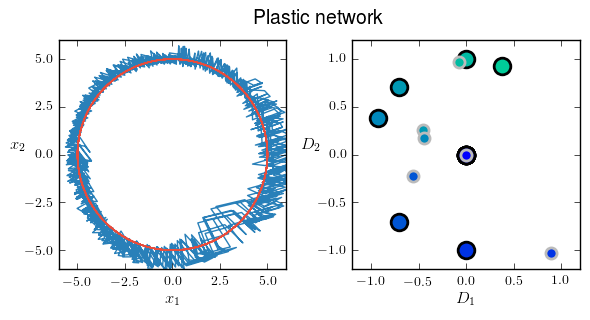

In [158]:
this_time = [int((T-50.)/dt), int(T/dt)]
f, ax = plot_signal_weights_hori(circ, abl_y, abl_F, abl_D, 5., 1., this_time, nolegend=True)
f.suptitle("Plastic network", fontsize=14, x=0.54, y = 1.05)
#f.subplots_adjust(wspace = .5)
plt.tight_layout()
f.savefig("./plots/Fig5A.svg", dpi=900)
plt.show()

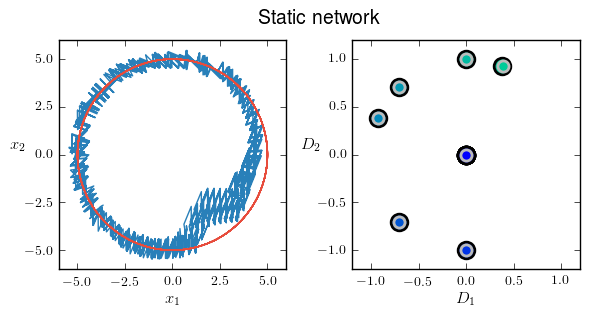

In [157]:
f, ax = plot_signal_weights_hori(circ, stat_y, stat_F, stat_D, 5., 1., this_time, nolegend=True)
f.suptitle("Static network", fontsize=14, x=0.54, y = 1.05)
#f.subplots_adjust(wspace = .5)
plt.tight_layout()
f.savefig("./plots/Fig5B.svg", dpi=900)
plt.show()

0.0
100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0
1000.0
1100.0
1200.0
1300.0
1400.0
1500.0
1600.0
1700.0
1800.0
1900.0
2000.0


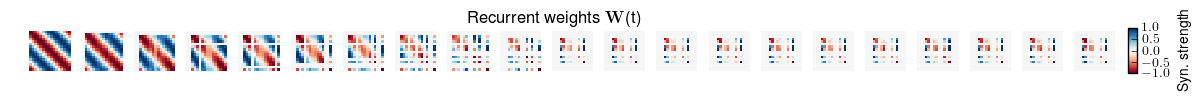

In [188]:
f, ax = plot_weight_evo(abl_Wo, abl_allW, 20, [0., T], _sc=14.)
f.savefig("./plots/Fig5C.svg", dpi=900)
plt.show()

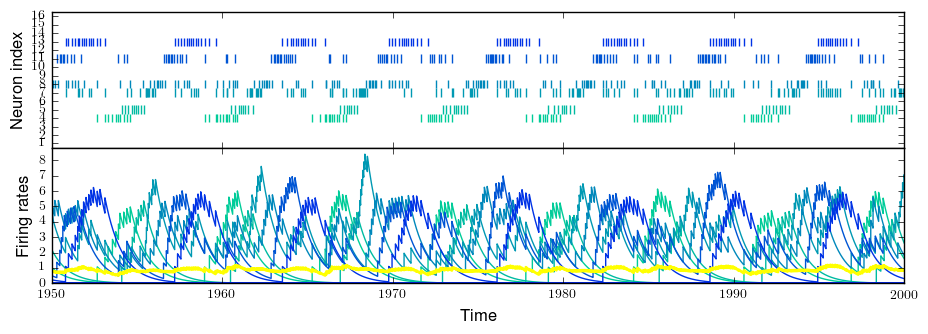

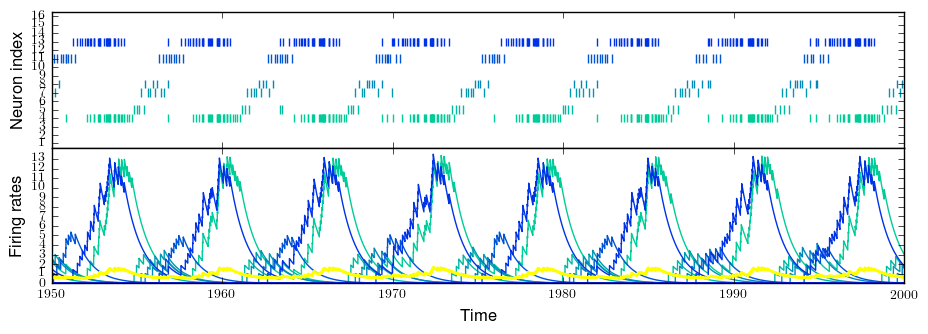

In [198]:
skip= 1
f, ax = plot_time_series(time[::skip], abl_o[:,::skip], abl_r[:,::skip], [int((T-50.)/dt), int(T/dt)], [11,3.5])
ax[0].set_xlim([T-50., T])
ax[1].set_xlim([T-50., T])
plt.show()
f, ax = plot_time_series(time[::skip], stat_o[:,::skip], stat_r[:,::skip], [int((T-50.)/dt), int(T/dt)], [11,3.5])
ax[0].set_xlim([T-50., T])
ax[1].set_xlim([T-50., T])
plt.show()

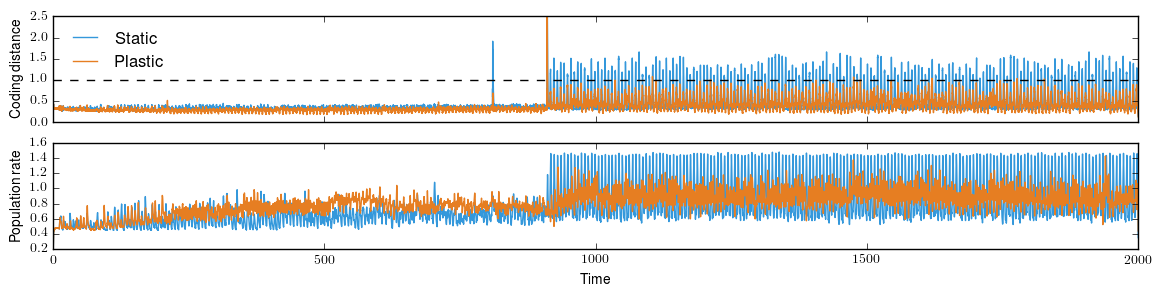

In [175]:
f, ax = plt.subplots(2,figsize=(14,3.), sharex=True)
sq_error = np.sqrt(((circ-abl_y)[0])**2 + ((circ-abl_y)[1])**2)
sq_error_stat = np.sqrt(((circ-stat_y)[0])**2 + ((circ-stat_y)[1])**2)

### some signal filtering
nyf = 0.5/dt
windsize = 1001
filt_error = sp.savgol_filter(sq_error, windsize, 3)
filt_error_stat = sp.savgol_filter(sq_error_stat, windsize, 3)

b, a = sp.butter(3, 0.5, 'low', analog=True)
but_error = sp.filtfilt(b, a, sq_error)
but_error_stat = sp.filtfilt(b, a, sq_error_stat)

wi_error = sp.wiener(sq_error, mysize=windsize, noise=0.5)
wi_error_stat = sp.wiener(sq_error_stat, mysize=windsize, noise=0.5)

#ax.plot(time[::skip], sq_error_stat[::skip], c=flatui["peter_river"])
#ax.plot(time[::skip], sq_error[::skip], c=flatui["carrot"])
ax[0].plot(time[::skip], wi_error_stat[::skip], "-", c=flatui["peter_river"], label="Static")
ax[0].plot(time[::skip], wi_error[::skip], "-", c=flatui["carrot"], label="Plastic")

## population rates
pop_rate = np.mean(abl_r,axis=0)  # population activity
stat_pop_rate = np.mean(stat_r,axis=0)  # population activity
pop_var = np.var(abl_r,axis=0)  # population variance
stat_pop_var = np.var(stat_r,axis=0)  # population variance

but_rate = sp.filtfilt(b, a, pop_rate)
but_rate_stat = sp.filtfilt(b, a, stat_pop_rate)
wi_rate = sp.wiener(pop_rate, mysize=windsize, noise=1.5)
wi_rate_stat = sp.wiener(stat_pop_rate, mysize=windsize, noise=1.5)
filt_rate = sp.savgol_filter(pop_rate, windsize, 3)
filt_rate_stat = sp.savgol_filter(stat_pop_rate, windsize, 3)

ax[1].plot(time[::skip], wi_rate_stat[::skip], "-", c=flatui["peter_river"])
ax[1].plot(time[::skip], wi_rate[::skip], "-", c=flatui["carrot"])



ax[0].plot([0,T], [1., 1.], 'k--')
#ax.plot([0,T], [2., 2.], 'r--')
ax[0].set_ylim([0,2.5])
ax[0].set_ylabel("Coding distance")
ax[1].set_ylabel(r"Population rate")
ax[0].legend(loc="upper left", ncol=1, frameon=False)
ax[1].set_xlabel("Time")
f.savefig("./plots/Fig5D.svg", dpi=900)
plt.show()

## 6. Join panels together into Figure 5 (using SVGs)

This cell could be put into a generic function using an array of files

Output size: 864px 510px


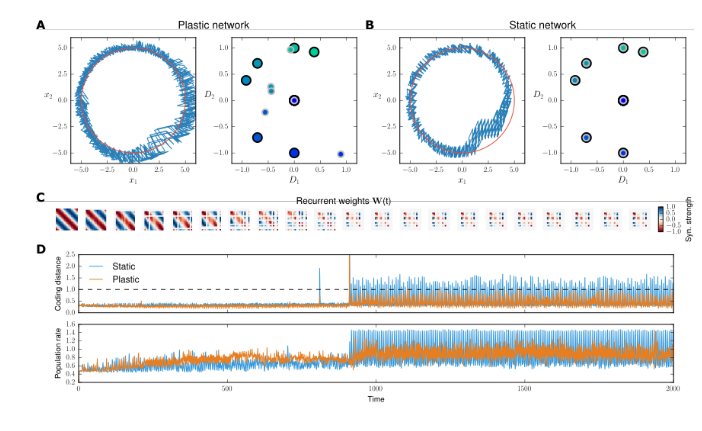

In [197]:
def toInt(string):
    return int(string.replace("pt", ""))

" join figures together "
#create new SVG figure
fig = sg.SVGFigure()

# load matpotlib-generated figures
curr_dir = "/Users/degoldschmidt/workspace/network-rotation/plots"
panels = [ sg.fromfile(curr_dir + "/Fig5A.svg"),
           sg.fromfile(curr_dir + "/Fig5B.svg"),
           sg.fromfile(curr_dir + '/Fig5C.svg'),
           sg.fromfile(curr_dir + '/Fig5D.svg')]

# get the plot objects and move them to right position
plots = []
sizes = []

for ind, panel in enumerate(panels):
    plots.append(panel.getroot())
    wid, hei = panel.get_size()
    sizes.append([toInt(wid), toInt(hei)])

offs = 50
anc = 0
yoff = 20
plots[0].moveto(anc, anc+yoff)
plots[1].moveto(anc+sizes[0][0], anc+yoff)

anc = 0
offx = 100
offx2 = 70
plots[2].moveto(anc-offx, sizes[0][1]+yoff+10)
plots[3].moveto(anc-offx2, sizes[2][1]+sizes[0][1]+yoff+10)
newwid = sizes[3][0]

newwid = str(sizes[0][0]+sizes[1][0])+"px"
newhei = str(sizes[2][1]+sizes[0][1] +sizes[3][1]+yoff+10)+"px"
print("Output size:",newwid, newhei)
fig.set_size([newwid, newhei])


# add text labels
fsize = 16
offs = 20
txtA = sg.TextElement(0,20, "A", size=fsize, weight="bold")
txtB = sg.TextElement(sizes[0][0],20, "B", size=fsize, weight="bold")
txtC = sg.TextElement(anc, sizes[0][1]+yoff+10, "C", size=fsize, weight="bold")
txtD = sg.TextElement(anc, sizes[2][1]+sizes[0][1]+yoff+30, "D", size=fsize, weight="bold")


# append plots and labels to figure
fig.append([plots[3], plots[2], plots[1], plots[0]])
fig.append([txtA, txtB, txtC, txtD])

# save generated SVG files
fig.save(curr_dir + "/Fig5.svg")
# svg-to-pdf conversion using Inkscape
inkscape = "/Applications/Inkscape.app/Contents/Resources/script --without-gui"
folder = "/Users/degoldschmidt/workspace/network-rotation/plots/"
filesvg = folder + "Fig5.svg"
filepdf = folder + "Fig5.pdf"
filepng = folder + "Fig5pre.png"
os.system(inkscape + " --export-pdf=" + filepdf + " " + filesvg)
os.system(inkscape + " --export-png=" + filepng + " " + filesvg)
# show preview png
plt.figure(figsize=(13,5))
image = mpimg.imread(filepng)
plt.imshow(image)
plt.axis("off")
plt.show()

## 7. Creating videos to show recurrent weight changes

5000000
(16, 16)
1000
0
200
400
600
800


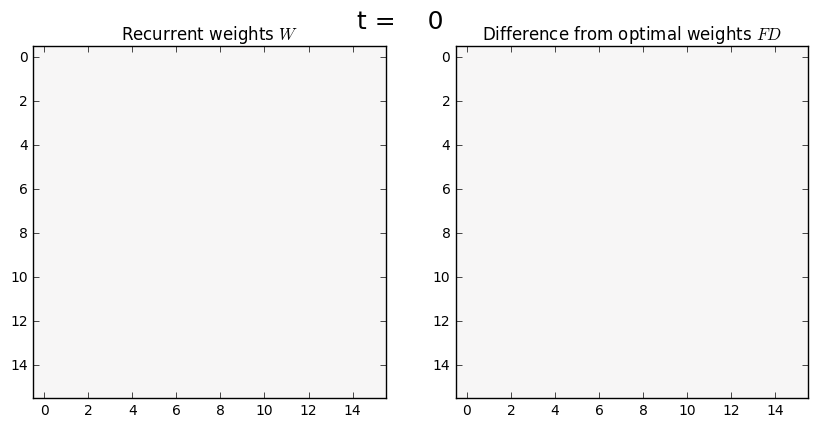

In [11]:
import matplotlib.image as img
from matplotlib import animation, rc
from IPython.display import HTML
from scipy import ndimage,misc

fig, ax = plt.subplots(1,2,figsize=(10,5))
print(len(allW))
print(allW[0].shape)
cbsc = 1
colmap = "RdBu_r"

skip = 5000     ##[ms]
reduce = 16
nallW = allW[::skip,:reduce,:reduce]

implot0 = ax[0].imshow((-nallW[0]), vmin=-cbsc, vmax=cbsc, cmap=colmap, animated=True, interpolation='none')
implot1 = ax[1].imshow((nallW[0]-Wopt1[:reduce,:reduce]), vmin=-cbsc, vmax=cbsc, cmap=colmap, animated=True, interpolation='none')
#implot2 = ax[2].imshow((y_low[:,10]).reshape(imgsize,imgsize), vmin=0.0, vmax=1.0, cmap="gray",animated=True, interpolation='none')
ax[0].set_title("Recurrent weights $W$") # $\mathbf{x}(t)$")
ax[1].set_title("Difference from optimal weights $FD$") # $\mathbf{x}(t)$")
#ax[2].set_title("Decoder y(t)") # $\mathbf{y}(t)$")
#for ind in range(3):
#    ax[ind].set_xticks(np.arange)
#    ax[ind].set_yticks([N])

time_template = 't = %4.0f'
time_text = ax[0].text(0.92, 1.05, '', fontsize=18, transform=ax[0].transAxes)

def init():
    implot0.set_data(np.zeros((N,N)))
    implot1.set_data(np.zeros((N,N)))
    time_text.set_text(time_template % (0*dt*skip))
    return [implot0, implot1, time_text]

def animate(i):
    new_W = -nallW[i]
    if i < tabl/(dt*skip):
        new_dW = (nallW[i]-Wopt1[:reduce,:reduce])
    else:
        new_dW = (nallW[i]-Wopt2[:reduce,:reduce])
    implot0.set_data(new_W)
    implot1.set_data(new_dW)
    fig.suptitle("", )
    if math.fmod(i,nallW.shape[0]/5)==0:
        print(i)
    time_text.set_text(time_template % (i*dt*skip))
    return [implot0, implot1, time_text]

print(nallW.shape[0])
nframes = nallW.shape[0]
vid_duration = 20.                                       # in secs
#FFMpegWriter = animation.writers['ffmpeg']

# Change the video bitrate as you like and add some metadata.
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=int(1*nframes), interval=vid_duration*(skip/nframes))
#plt.show() #, fps=100, writer=animation.FFMpegWriter(), codec="libx264", bitrate=-1, extra_args=['-pix_fmt', 'yuv420p']
ani.save('./videos/video-Fig4.mp4', dpi=300)


In [12]:
HTML(ani.to_html5_video())

0
200
400
600
800
